# Capstone Project - The Battle of the Neighbourhoods (Week 5)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction:](#introduction)
* [Business Problem:](#BusinessProblem)
* [Data & Methodology:](#data)
* [Data Exploration && Data Analysis:](#dataExpAna)
* [Results and Discussion:](#results)
* [Conclusion:](#conclusion)

## Introduction:  <a name="introduction"></a>

Today, we have more intellects on this planet than ever before. As the intellect becomes stronger, people look for logical solutions. 
More and more people are realizing physical activity is important for Fitness & Mental well-being of an individual.

There are different types of Fitness & mental well-being center's, such as GYM, Yoga, Aerobics, Boxing, Pool, recreation centers, Gymnastics and Martial Arts School etc.

Each type has its own benefits and its own style.

Toronto is the capital city of the Canadian province of Ontario. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada and the fourth most populous city in North America.
Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

Starting a **Fitness & Mental well-being center** in **Toronto, Ontario, Canada** in a right Neighbourhood can be highly rewarding.

## Business Problem: <a name="BusinessProblem"></a>

In this project we will try to find an optimal location for starting a **Fitness & mental well-being center**.

This report will be targeted to stakeholders interested in opening a **Fitness & Mental well-being center** in **Toronto, Ontario, Canada**

We will use our data science powers to identify neighbourhoods  and show which type of Fitness & Mental well-being center can be launched.

Advantages of each neighbourhoods  will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data & Methodology <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* Different types of fitness centers in a neighbourhood .
* Density  of fitness centers in a neighbourhood .
* Combination of fitness centers in a neighbourhood .

Following data sources will be needed to extract/generate the required information:
* List of neighbourhood of Toronto will be gathered from wikipage **https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M**
* List of fitness centers and their location in every neighbourhood will be obtained using **Foursquare API**
* List of Toronto neighborhood coordinates from **http://cocl.us/Geospatial_data**

Following steps performed as part of this exercise.
*	In the First step we will be collecting the list of neighbourhoods in Toronto and clean the data.
*	As a second step for each neighbourhood we shall collect list of Fitness or wellness centers in a radius of 500 meters and clean the data.
*	For Third step we will identify market share of different types of Fitness or wellness centers and as well how Fitness or Wellness centers spread across the neighbourhoods.
*	In Fourth step we will segregate the neighbourhoods into clusters using K means based on the most popular venues in each neighbourhood.
*	As a part of fifth and final step, we will merge clusters with count of venues in each neighbourhood, to search for optimal venue location by stakeholders.

#### Declaring the needed modules.

In [229]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
#import warnings
#warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

#### Fetching data from Wiki page and cleaning up Borough's which are not assigned

In [230]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
dfs=pd.read_html(url)
df=dfs[0]
df=df[df['Borough']!="Not assigned"]
df.reset_index(drop=True, inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Fetching Geospatial_Coordinates (Latitide and Longitude) for all the neighbourhoods of Toronto.

In [231]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data

In [232]:
gd=pd.read_csv("Geospatial_Coordinates.csv")
gd.shape

(103, 3)

In [233]:
df=df.set_index('Postal Code')
gd=gd.set_index('Postal Code')

FD=pd.concat([df,gd],axis=1)
FD.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Data Exploration && Data Analysis <a name="dataExpAna"></a>

#### Creating a map of Toronto and mapping the neighborhood and borough on the map

In [234]:
#Fetching Toronto Latitude and Longitude.
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
Toronto_latitude = location.latitude
Toronto_longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(Toronto_latitude, Toronto_longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [235]:
#Using folium to MAP the neighborhood on Map of Toronto.
map_toronto = folium.Map(location=[Toronto_latitude, Toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(FD['Latitude'], FD['Longitude'], FD['Borough'], FD['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### From FOURSQUARE API we will be fetching list of FITNESS/WELLNESS venue's for each neighborhood 
#### To optimize the results we will be using [category '4bf58dd8d48988d175941735', https://developer.foursquare.com/docs/build-with-foursquare/categories/]

In [236]:
#Defining defaults for Four Square API usage.
CLIENT_ID = 'ID'
CLIENT_SECRET = 'Password'

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 #lets fix by default radius as 500m

In [237]:
#Defining procedure getNearbyVenues, which returns a data frame with columns "'Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 
#'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'"

def getNearbyVenues(category, names, latitudes, longitudes,radius=500): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [238]:
#Define cateogry, based on https://developer.foursquare.com/docs/build-with-foursquare/categories/
#yoga='4bf58dd8d48988d102941735' #yoga
#gym='4bf58dd8d48988d175941735' #gym

category='4bf58dd8d48988d175941735'
toronto_venues_orig = getNearbyVenues(category,
                                      names=FD['Neighbourhood'],
                                      latitudes=FD['Latitude'],
                                      longitudes=FD['Longitude']
                                      )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [239]:
# save the result from Four square API to a csv file.
toronto_venues_orig.to_csv('venues_output.csv')

In [240]:
# We shall use the data from venues_output.csv going further in our analysis.
toronto_venues=pd.read_csv('venues_output.csv')
print("Count of venues returned by 4square API for neighborhoods",toronto_venues.shape[0])
toronto_venues.head()

Count of venues returned by 4square API for neighborhoods 373


,Unnamed: 0,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
1,1,"Regent Park, Harbourfront",43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
2,2,"Regent Park, Harbourfront",43.654260,-79.360636,Corktown District Lofts Gym,43.655652,-79.358125,Gym
3,3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Body Language Fitness,43.717784,-79.466233,Gym / Fitness Center
4,4,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,All-in-One Strength & Conditioning / CrossFit AIO,43.719187,-79.468886,Gym


In [241]:
#See the List of unique Fitness and wellness centers cateogry's.

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues['Venue Category'].value_counts()

There are 13 uniques categories.


Gym / Fitness Center    141
Gym                     139
Yoga Studio              52
Martial Arts School      18
Gym Pool                 12
Hotel Pool                2
Pilates Studio            2
Boxing Gym                2
Gymnastics Gym            1
College Rec Center        1
Cycle Studio              1
Climbing Gym              1
College Gym               1
Name: Venue Category, dtype: int64

#### few of the cateogries are very small, to optimize lets cateogrize the categories to 5 unique values 
1) Fitness Center ===> from 'Gym / Fitness Center'

2) Gym            ===> from 'Gym'

3) Yoga           ===> from 'Yoga Studio'

4) Martial Arts   ===> from 'Martial Arts School'

5) Other's        ===> from 'Gym Pool', 'Hotel Pool', 'Pilates Studio', 'Boxing Gym', 'Gymnastics Gym', 'College Rec Center', 'Cycle Studio', 'Climbing Gym', 'College Gym'

In [242]:
for i,row in toronto_venues.iterrows():
    if row['Venue Category'] == 'Gym / Fitness Center':
        toronto_venues.at[i,'Venue Category'] = 'Fitness Center'
    elif row['Venue Category'] == 'Yoga Studio':
        toronto_venues.at[i,'Venue Category'] = 'Yoga'
    elif row['Venue Category'] == 'Gym':
        toronto_venues.at[i,'Venue Category'] = 'Gym'
    elif row['Venue Category'] == 'Martial Arts School':
        toronto_venues.at[i,'Venue Category'] = 'Martial Arts'
    else:
        toronto_venues.at[i,'Venue Category'] = 'Others'

#### Checking cateogry's Fitness and Wellness centers 

In [243]:
#See the List of unique Fitness and wellness centers cateogry's.

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues_cat_uni=toronto_venues['Venue Category'].value_counts().to_frame()
toronto_venues_cat_uni.reset_index(inplace=True)
toronto_venues_cat_uni

There are 5 uniques categories.


,index,Venue Category
0,Fitness Center,141
1,Gym,139
2,Yoga,52
3,Others,23
4,Martial Arts,18


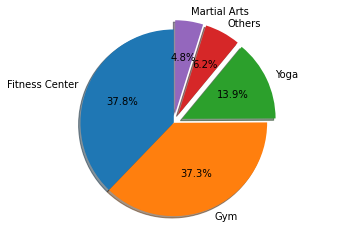

In [244]:
explode = (0, 0, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(toronto_venues_cat_uni['Venue Category'], explode=explode, labels=toronto_venues_cat_uni['index'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Checking how the Fitness and Wellness centers are spread across the Neighbourhood

In [247]:
toronto_venues_cat=toronto_venues[['Neighbourhood','Venue Category']].groupby('Neighbourhood').count().sort_values(by=['Venue Category'],ascending=False)
toronto_venues_cat1=toronto_venues_cat.reset_index()
toronto_venues_cat1.head(15)

,Neighbourhood,Venue Category
0,"Richmond, Adelaide, King",24
1,"First Canadian Place, Underground city",22
2,"Commerce Court, Victoria Hotel",22
3,Church and Wellesley,20
4,Central Bay Street,18
5,"Toronto Dominion Centre, Design Exchange",18
6,St. James Town,17
7,"Garden District, Ryerson",17
8,Stn A PO Boxes,15
9,"Harbourfront East, Union Station, Toronto Islands",13


<BarContainer object of 62 artists>

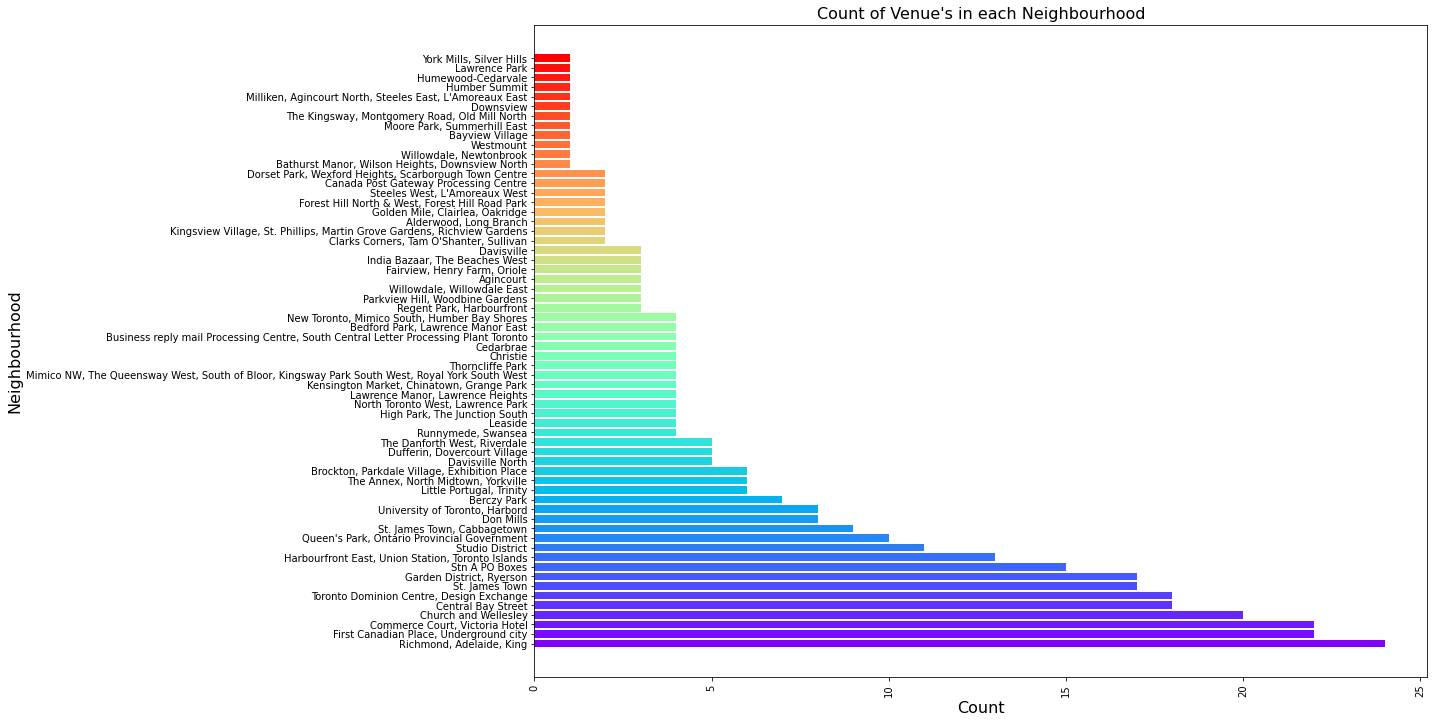

In [249]:
colors = cm.rainbow(np.linspace(0, 1, len(toronto_venues_cat1['Neighbourhood'].index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Neighbourhood", fontsize = 16)
plt.title("Count of Venue's in each Neighbourhood", fontsize = 16)
plt.barh(toronto_venues_cat1['Neighbourhood'], toronto_venues_cat1['Venue Category'], color = colors)

#### Lets show percentage of Market share capture by Neighbourhoods.
#### Minitue < 2, Low < 5, Medium < 10, High > 10

In [250]:
toronto_n_sum=[0,0,0,0]
toronto_n_count=[0,0,0,0]
for i in toronto_venues_cat['Venue Category'].values.tolist():
    if i < 2:
        toronto_n_sum[0]=toronto_n_sum[0]+i
        toronto_n_count[0]=toronto_n_sum[0]+1
    elif i < 5:
        toronto_n_sum[1]=toronto_n_sum[1]+i
        toronto_n_count[1]=toronto_n_count[1]+1
    elif i < 10:
        toronto_n_sum[2]=toronto_n_sum[2]+i
        toronto_n_count[2]=toronto_n_count[2]+1
    else:
        toronto_n_sum[3]=toronto_n_sum[3]+i
        toronto_n_count[3]=toronto_n_count[3]+1

tor_n=['Minute_count==>'+str(toronto_n_count[0]), 'Low_count==>'+str(toronto_n_count[1]), 'Medium_count==>'+str(toronto_n_count[2]), 'High_count==>'+str(toronto_n_count[3])]

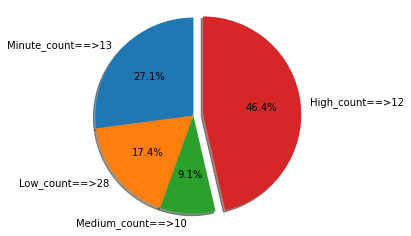

In [251]:
explode = (0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(toronto_n_test, explode=explode, labels=tor_n, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Analyze Each Neighbourhood on Venues from 4Square data

In [252]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [253]:
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.rename(columns = {'Gym / Fitness Center':'Fitness Center'},inplace=True)
print(toronto_onehot.shape)
toronto_onehot.head(10)

(373, 6)


,Neighbourhood,Fitness Center,Gym,Martial Arts,Others,Yoga
0,"Regent Park, Harbourfront",1,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,1
2,"Regent Park, Harbourfront",0,1,0,0,0
3,"Lawrence Manor, Lawrence Heights",1,0,0,0,0
4,"Lawrence Manor, Lawrence Heights",0,1,0,0,0
5,"Lawrence Manor, Lawrence Heights",0,0,0,1,0
6,"Lawrence Manor, Lawrence Heights",0,0,0,1,0
7,"Queen's Park, Ontario Provincial Government",0,1,0,0,0
8,"Queen's Park, Ontario Provincial Government",0,0,0,0,1
9,"Queen's Park, Ontario Provincial Government",0,1,0,0,0


In [254]:
# groupby Neighbourhood and by taking the mean of the frequency of occurrence of each category

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head(10)

(62, 6)


,Neighbourhood,Fitness Center,Gym,Martial Arts,Others,Yoga
0,Agincourt,0.000000,0.333333,0.666667,0.000000,0.000000
1,"Alderwood, Long Branch",0.500000,0.500000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,1.000000
3,Bayview Village,0.000000,1.000000,0.000000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.250000,0.250000,0.000000,0.250000,0.250000
5,Berczy Park,0.285714,0.428571,0.000000,0.142857,0.142857
6,"Brockton, Parkdale Village, Exhibition Place",0.166667,0.333333,0.000000,0.166667,0.333333
7,"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",0.500000,0.000000,0.250000,0.000000,0.250000
8,Canada Post Gateway Processing Centre,1.000000,0.000000,0.000000,0.000000,0.000000
9,Cedarbrae,0.500000,0.250000,0.250000,0.000000,0.000000


In [255]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [256]:
#Lets gather top 3 cateogries from each neighbourhood.

num_top_venues = 3 #hardcoded.

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Martial Arts,Gym,Fitness Center
1,"Alderwood, Long Branch",Fitness Center,Gym,Martial Arts
2,"Bathurst Manor, Wilson Heights, Downsview North",Yoga,Fitness Center,Gym
3,Bayview Village,Gym,Fitness Center,Martial Arts
4,"Bedford Park, Lawrence Manor East",Fitness Center,Gym,Others
5,Berczy Park,Gym,Fitness Center,Others
6,"Brockton, Parkdale Village, Exhibition Place",Gym,Yoga,Fitness Center
7,"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",Fitness Center,Martial Arts,Yoga
8,Canada Post Gateway Processing Centre,Fitness Center,Gym,Martial Arts
9,Cedarbrae,Fitness Center,Gym,Martial Arts


#### Performing Clustering Neighbourhood's based on Most common Venue.

In [257]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1) #dropping neighbourhood

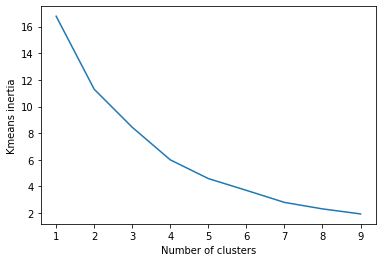

In [258]:
#Using Elbow method to identify the "K"

ELM = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    ELM[k] = kmeans.inertia_

plt.figure()
plt.plot(list(ELM.keys()), list(ELM.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Kmeans inertia")
plt.show()

In [259]:
# We don't have very clear and sharp Elbow curve, We can have either 3 or 4 as K.
#Lets choose cluster as 4.
kclusters=4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] #sample of cluster labels

array([2, 3, 0, 1, 0, 3, 0, 3, 3, 3], dtype=int32)

In [260]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = FD

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.dropna(axis=0,inplace=True)
toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Postal Code,,,,,,,,
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Fitness Center,Gym,Yoga
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3.0,Others,Fitness Center,Gym
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3.0,Fitness Center,Gym,Yoga
M3B,North York,Don Mills,43.745906,-79.352188,3.0,Fitness Center,Gym,Yoga
M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0.0,Fitness Center,Gym,Yoga


#### Lets map the clusters on the Toronto Map.

In [261]:
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[Toronto_latitude, Toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Add Total Venues field in each neighbourhood.

In [262]:
toronto_merged = toronto_merged.join(toronto_venues_cat, on='Neighbourhood')
toronto_merged.rename(columns={'Venue Category':'Total No of Venues'}, inplace=True)
toronto_merged.head(10)

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total No of Venues
Postal Code,,,,,,,,,
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Fitness Center,Gym,Yoga,3
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3.0,Others,Fitness Center,Gym,4
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3.0,Fitness Center,Gym,Yoga,10
M3B,North York,Don Mills,43.745906,-79.352188,3.0,Fitness Center,Gym,Yoga,8
M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0.0,Fitness Center,Gym,Yoga,3
M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3.0,Fitness Center,Gym,Others,17
M3C,North York,Don Mills,43.725900,-79.340923,3.0,Fitness Center,Gym,Yoga,8
M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3.0,Fitness Center,Gym,Yoga,17
M6C,York,Humewood-Cedarvale,43.693781,-79.428191,1.0,Gym,Fitness Center,Martial Arts,1


#### Analyse Clusters

#### Cluster1

In [263]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].sort_values(by=['Total No of Venues'],ascending=False)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total No of Venues
Postal Code,,,,,
M4M,Studio District,Gym,Yoga,Others,11
M4X,"St. James Town, Cabbagetown",Gym,Fitness Center,Martial Arts,9
M5S,"University of Toronto, Harbord",Gym,Yoga,Others,8
M6K,"Brockton, Parkdale Village, Exhibition Place",Gym,Yoga,Fitness Center,6
M5R,"The Annex, North Midtown, Yorkville",Gym,Yoga,Fitness Center,6
M8V,"New Toronto, Mimico South, Humber Bay Shores",Gym,Fitness Center,Yoga,4
M4G,Leaside,Gym,Fitness Center,Yoga,4
M6G,Christie,Fitness Center,Yoga,Gym,4
M4H,Thorncliffe Park,Yoga,Fitness Center,Gym,4


#### Cluster2

In [264]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].sort_values(by=['Total No of Venues'],ascending=False)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total No of Venues
Postal Code,,,,,
M2J,"Fairview, Henry Farm, Oriole",Gym,Yoga,Fitness Center,3
M2N,"Willowdale, Willowdale East",Gym,Fitness Center,Martial Arts,3
M1L,"Golden Mile, Clairlea, Oakridge",Gym,Fitness Center,Martial Arts,2
M9R,"Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens",Gym,Fitness Center,Martial Arts,2
M6C,Humewood-Cedarvale,Gym,Fitness Center,Martial Arts,1
M2K,Bayview Village,Gym,Fitness Center,Martial Arts,1
M9L,Humber Summit,Gym,Fitness Center,Martial Arts,1
M2M,"Willowdale, Newtonbrook",Gym,Fitness Center,Martial Arts,1
M4T,"Moore Park, Summerhill East",Gym,Fitness Center,Martial Arts,1


#### Cluster 3

In [265]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].sort_values(by=['Total No of Venues'],ascending=False)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total No of Venues
Postal Code,,,,,
M1S,Agincourt,Martial Arts,Gym,Fitness Center,3
M1P,"Dorset Park, Wexford Heights, Scarborough Town Centre",Gym,Martial Arts,Fitness Center,2
M2L,"York Mills, Silver Hills",Martial Arts,Fitness Center,Gym,1
M9P,Westmount,Martial Arts,Fitness Center,Gym,1


#### Cluster 4

In [266]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].sort_values(by=['Total No of Venues'],ascending=False)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total No of Venues
Postal Code,,,,,
M5H,"Richmond, Adelaide, King",Gym,Fitness Center,Others,24
M5X,"First Canadian Place, Underground city",Fitness Center,Gym,Martial Arts,22
M5L,"Commerce Court, Victoria Hotel",Fitness Center,Gym,Yoga,22
M4Y,Church and Wellesley,Gym,Fitness Center,Yoga,20
M5K,"Toronto Dominion Centre, Design Exchange",Fitness Center,Gym,Martial Arts,18
M5G,Central Bay Street,Fitness Center,Gym,Yoga,18
M5B,"Garden District, Ryerson",Fitness Center,Gym,Others,17
M5C,St. James Town,Fitness Center,Gym,Yoga,17
M5W,Stn A PO Boxes,Fitness Center,Gym,Yoga,15


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a good number of Fitness/Wellness centers in Toronto, But we have first identified how different types of Fitness and wellness centers trends in the neighbourhoods. **75% Market share** is captured by **GYM & Fitness centers (aerobics etc)** and **Yoga**, which is currently highly popular has just **14% market share**. Martial Arts just hold 5% market share, and remaining types such as Boxing, Pools, Gymnastics, climbing studio's hold just 5% Market share. There is still potential of the market share capturing for Yoga, Martial arts, and Climbing studios etc. 

On analysis of how fitness/wellness centers are spread across the neighbourhood, We can see that **50%** of the Total fitness/wellness centers are present in **12** Neighbourhoods. There are **13** neighbourhoods which has just **1** fitness/wellness centers which holds for **28%** for neighbourhoods. These less desinty neighbourhoods potential for new fitness/wellness centers.

Neighbourhoods clustering was then performed, with K-measns clustering, by exploring the frequency of the type of Fitness/Wellness center's available in each neighbourhood. By using elbow method we have concluded that optimal value for number of clusters can be either 3 or 4, we have chosen to stick with 4 clusters after verifying the generated clusters.

* Cluster 0 contains neighbourhoods which has GYM, Fitness centers and Yoga as preference.
* Cluster 1 contains neighbourhoods which has GYM as Major preference. 
* Cluster 2 contains neighbourhoods which has Martial Art schools as preference.
* And last Cluster 4 has GYM, Fitness centers and Yoga as favourites And Cluster 4 also holds high density fitness centers neighbourhoods.

Purpose of this analysis was to show how the distribution of types of Fitness/Wellness centers across neighbourhoods and as well as share of Fitness/Wellness centers across the neighbourhoods.
Clustered data clubbed with Market share analysis shall be used as starting points for final exploration by stakeholders.

> *Report uploaded to GIT has more details Results and Discussion*


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify optimal neighbourhood and type of fitness or wellness center in Toronto neighbourhoods. From Foursquare data we have first identified how different types of Fitness and wellness centers trends in the neighbourhoods. **75% Market share** is captured by **GYM & Fitness centers (aerobics etc)** and **Yoga**, which is currently highly popular has just **14% market share**. Martial Arts just hold 5% market share, and remaining types such as Boxing, Pools, Gymnastics, climbing studio's hold just 5% Market share. 

On analysis of how fitness/wellness centers are spread across the neighbourhood, We can see that **50%** of the Total fitness/wellness centers are present in **12** Neighbourhoods. There are **13** neighbourhoods which has just **1** fitness/wellness centers which holds for **28%** for neighbourhoods.

Neighbourhoods clustering was then performed, with K-means clustering, by exploring the frequency of the type of Fitness/Wellness center's available in each neighbourhood. Further Identified Clusters are clubbed with density of Fitness/Wellness center's in each neighbourhood, which to be used as starting points for final exploration by stakeholders.

Final decision on optimal location and type of fitness or wellness center will be made by stakeholders based on specific characteristics of neighbourhoods and locations in every Cluster, Such as attractiveness of each location, Population in the neighbourhoods, Connectivity, real estate availability, prices, social and economic dynamics of every neighborhood etc.